# <span style = 'color:darkred'> Set notebook to full width </span style>

In [1]:
from py4j.java_gateway import JavaGateway, GatewayParameters # Bridge between Python and Java
gateway = JavaGateway(gateway_parameters=GatewayParameters(port=25333))

SyntaxError: invalid syntax (<ipython-input-47-0a93766e12be>, line 1)

In [53]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# <span style = 'color:darkred'> Notebook structure </span style>

- ### <a href=#imports> Imports  </a>
- ### <a href=#read_in> Reading in (sub)set </a>
- ### <a href=#tickers_ipo_extraction> Extracting ticker formatted strings and tweets containing IPO </a>
- ### <a href=#redun_columns> Drop standard redundant columns after checking</a>
- ### <a href=#expand_subcols> Expand the subcolumns that do not contain WrapperArrays </a>
- ### <a href=#check_and_drop_redundant_cols> Check for non-standard redundant columns and drop them </a>
- ### <a href=#none> ... </a>



# <span style = 'color:darkred'> Imports </span style>

In [54]:
import os
import pandas as pd
import sys
import re
import csv
#os.environ['SPARK_HOME'] = 'D:/School/STAGE_BP/spark'
#import findspark
#findspark.init(spark_home = "/home/sachadubrulle/spark-2.1.0")
import pyspark

from pyspark.sql import SQLContext, SparkSession

try:
    sc = pyspark.SparkContext(appName = 'App')
    spark = SparkSession(sparkContext=sc)
    print("SparkSession initialized")
except ValueError:
    print("SparkSession already initialized")

SparkSession already initialized


In [55]:
spark=pyspark.sql.SparkSession.builder.appName('Bottom-Up-Analysis').config('spark.driver.memory','8G').getOrCreate()

# <span style = 'color:darkred'> To do </span style>

- Add remaining 7000 tweets that are not yet included for 2016
- Based on tweets with a known ticker -> find tweets based on language analysis that talk about IPO without necessarilty containing a tickerm

# <span style = 'color:darkred'> Imports </span style> <a name='imports' />

In [4]:
# Python imports
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import glob

# Spark imports
from pyspark.sql.functions import udf, year, month, dayofmonth, explode, lower, regexp_extract, split, upper, col, regexp_replace
from pyspark.sql.types import *
import time
from datetime import datetime
import imp


# <span style = 'color:darkred'> ETL </span style> <a name='read_in' />

## <span style = 'color:green'> Reading in tweets </span style> <a name='read_in' />

In [5]:
cd /home/mma/Downloads/IPO_project/commented_files/

/home/mma/Downloads/IPO_project/commented_files


In [6]:
# Read in functions from external file written in python and should be present in the same directory,
# Where this file is running from
import functions as f_ipo

f_ipo = imp.reload(f_ipo)

In [7]:
# Transform paterns. We are defining functions, with the functions we just imported.

#Extracting all cashtags from the tweets
udf_cashtag_re_extract = udf(f_ipo.cashtag_re_extract, ArrayType(elementType = StringType()))
#Gives the count of the mentions of the company's name
udf_contains_company_name = udf(f_ipo.contains_company_name, IntegerType())
non_empty_column_udf = udf(f_ipo.non_empty_column)
udf_contains_pattern = udf(f_ipo.contains_pattern)

# Define UDF to transform timestamp from StringType to TimestampType
udf_datatime = udf(lambda string: datetime.strptime(string, "%a %b %d %H:%M:%S +0000 %Y"), TimestampType())

udf_day_of_week = udf(lambda x: str(x.strftime('%A')), StringType())

In [8]:
#cashtag_expression is a regex that filters out everything that starts with $ and has 1-6 letters
cashtag_expression = "(\$[a-z]{1,6})+"
cashtag_expression_including_spaces = '\s\$[a-z]{1,6}\s' #add spaces to the cashtag
ipo_expression = ' #ipo | ipo ' 

In [9]:
from IPython.display import display  
from ipywidgets import FloatProgress  
import time


# saving the file path
path = "/home/mma/Downloads/IPO_Mining/tweets/*.json"

df = (spark.read.json('/home/mma/Downloads/IPO_Mining/tweets/*.json')

      
        # Add lower text column and timestamp
        .select("*", 
               udf_datatime(col("created_at")).alias("timestamp"),
               lower(col("text")).alias("text_lower")
               )
        # Drop created_at string column
        .drop("created_at")
        # Add columns related to ipo, cashtags & retweet patterns
        .select("*", 
               udf_cashtag_re_extract('text_lower').alias("cashtags"),
               non_empty_column_udf(regexp_extract('text_lower', ipo_expression, 0)).alias("contains_ipo"),
               non_empty_column_udf(regexp_extract('text_lower', cashtag_expression, 0)).alias("contains_cashtag"),
               non_empty_column_udf(regexp_extract('text_lower', cashtag_expression_including_spaces, 0)).alias("contains_cashtag_with_spaces"),
               udf_contains_company_name("text_lower").alias("contains_company_name"),
               regexp_extract(str = "text", pattern = "^RT @[A-Za-z0-9]+: ", idx = 0).alias("retweet_pattern")
               )
        .select("*", 
               udf_contains_pattern("retweet_pattern").alias("contains_RT_pattern")
              )
     )


#saving the column names
original_columns = df.columns

#selecting required columns
df = (df.withColumnRenamed("id_str", "tweet_id_str") #rename to avoid confusion with user_id, retweet_id, ...
        .withColumn("user_id_str", df.user.id_str) 
        .select("*")
     )

print("The original columns were: {}".format(original_columns))


The original columns were: ['contributors', 'coordinates', 'display_text_range', 'entities', 'extended_entities', 'extended_tweet', 'favorite_count', 'favorited', 'filter_level', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place', 'possibly_sensitive', 'quote_count', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink', 'reply_count', 'retweet_count', 'retweeted', 'retweeted_status', 'source', 'text', 'timestamp_ms', 'truncated', 'user', 'withheld_in_countries', 'timestamp', 'text_lower', 'cashtags', 'contains_ipo', 'contains_cashtag', 'contains_cashtag_with_spaces', 'contains_company_name', 'retweet_pattern', 'contains_RT_pattern']


In [10]:
df.count()

66000

In [11]:
df = df.select("*").filter('lang == "en"')

In [12]:
df.columns

['contributors',
 'coordinates',
 'display_text_range',
 'entities',
 'extended_entities',
 'extended_tweet',
 'favorite_count',
 'favorited',
 'filter_level',
 'geo',
 'id',
 'tweet_id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'possibly_sensitive',
 'quote_count',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status_permalink',
 'reply_count',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'timestamp_ms',
 'truncated',
 'user',
 'withheld_in_countries',
 'timestamp',
 'text_lower',
 'cashtags',
 'contains_ipo',
 'contains_cashtag',
 'contains_cashtag_with_spaces',
 'contains_company_name',
 'retweet_pattern',
 'contains_RT_pattern',
 'user_id_str']

In [13]:
df_tickers=df

In [14]:
ticker_expression_no_numbers = '(\s\$[A-Za-z]{1,6})+'
ticker_expression_including_numbers = '\$[A-Za-z0-9]{1,6}'
ipo_expression = '#ipo|ipo|#IPO|IPO'

df_tickers = (df.withColumn("tickers", regexp_extract('text', ticker_expression_no_numbers, 0))
                .withColumn("contains_ipo", regexp_extract('text', ipo_expression, 0))
            )

In [15]:
# Filter full dataset for tweets that contain either a ticker-pattern or the IPO pattern
df_tickers_and_ipo = df_tickers.filter((df_tickers["tickers"] != "") | (df_tickers["contains_ipo"] != ""))

print("There are {} tweets in the total set that containt the word ipo or a pattern that matches a ticker, including the dollar sign".format(df_tickers.count()))

#df_tickers_and_ipo.select("tweet_id_str", "contains_ipo", "tickers").show(5)
#df.createOrReplaceTempView("dfSQL")

There are 53613 tweets in the total set that containt the word ipo or a pattern that matches a ticker, including the dollar sign


In [16]:
# Filter out the tweets that contain one or multiple tickers
df_tickers = (df_tickers_and_ipo.filter(df_tickers_and_ipo["tickers"] != ""))


df_tickers = (df_tickers.select('contributors','coordinates','display_text_range','entities','extended_entities','extended_tweet','favorite_count','favorited','filter_level','geo','id','tweet_id_str','in_reply_to_screen_name','in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place', 'possibly_sensitive', 'quote_count', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'reply_count', 'retweet_count', 'retweeted', 'retweeted_status', 'source', 'text', 'timestamp_ms', 'truncated', 'user', 'withheld_in_countries', 'timestamp', 'text_lower','cashtags','contains_ipo','contains_cashtag','contains_cashtag_with_spaces','contains_company_name','retweet_pattern','contains_RT_pattern','user_id_str', split(df_tickers.tickers, '\s\$').alias('tickers')))


df_tickers = df_tickers.withColumn("ticker", explode(df_tickers.tickers))
df_tickers = df_tickers.filter(df_tickers.ticker != "")

aggregated_tickers = (df_tickers.withColumn("ticker", upper(df_tickers.ticker))
                                .groupBy("ticker").count()
                                .withColumnRenamed('count', "ticker_occurence")
                     )
aggregated_tickers = aggregated_tickers.sort(aggregated_tickers.ticker_occurence.desc())

#aggregated_tickers.coalesce(1).write.csv("ticker_occurence_2016", mode = "overwrite")


In [18]:
df_profit = pd.read_csv("/home/mma/Downloads/IPO_Mining/stock_mining/profit.csv") 

FileNotFoundError: [Errno 2] File b'/home/mma/Downloads/IPO_Mining/stock_mining/profit.csv' does not exist: b'/home/mma/Downloads/IPO_Mining/stock_mining/profit.csv'

In [ ]:
#df.select("entities").show(10, truncate = False)

In [ ]:
#df.printSchema()
#df.select("retweeted_status").rdd.take(1)

## <span style = 'color:darkgreen'> Extracting tickers & presence of IPO out of text </span style> <a name='tickers_ipo_extraction' />

 - containing $-sign in the text or containing ipo

In [ ]:
'''# REGEX to extract tickers or presence of IPO
ticker_expression_no_numbers = '(\s\$[A-Za-z]{1,6})+'
ticker_expression_including_numbers = '\$[A-Za-z0-9]{1,6}'
ipo_expression = '#ipo|ipo|#IPO|IPO'

df_tickers = (df.withColumn("tickers", regexp_extract('text', ticker_expression_no_numbers, 0))
                .withColumn("contains_ipo", regexp_extract('text', ipo_expression, 0))
            )'''

In [ ]:
'''df_tickers.columns'''

In [ ]:
'''# Filter full dataset for tweets that contain either a ticker-pattern or the IPO pattern
df_tickers_and_ipo = df_tickers.filter((df_tickers["tickers"] != "") | (df_tickers["contains_ipo"] != ""))

print("There are {} tweets in the total set that containt the word ipo or a pattern that matches a ticker, including the dollar sign".format(df_tickers.count()))

#df_tickers_and_ipo.select("tweet_id_str", "contains_ipo", "tickers").show(5)
#df.createOrReplaceTempView("dfSQL")'''

In [ ]:
'''# Filter out the tweets that contain one or multiple tickers
df_tickers = (df_tickers_and_ipo.filter(df_tickers_and_ipo["tickers"] != ""))


df_tickers = (df_tickers.select('contributors','coordinates','display_text_range','entities','extended_entities','extended_tweet','favorite_count','favorited','filter_level','geo','id','tweet_id_str','in_reply_to_screen_name','in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place', 'possibly_sensitive', 'quote_count', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink', 'reply_count', 'retweet_count', 'retweeted', 'retweeted_status', 'source', 'text', 'timestamp_ms', 'truncated', 'user', 'withheld_in_countries', 'timestamp', 'text_lower','cashtags','contains_ipo','contains_cashtag','contains_cashtag_with_spaces','contains_company_name','retweet_pattern','contains_RT_pattern','user_id_str', split(df_tickers.tickers, '\s\$').alias('tickers')))

df_tickers = df_tickers.withColumn("ticker", explode(df_tickers.tickers))
df_tickers = df_tickers.filter(df_tickers.ticker != "")

aggregated_tickers = (df_tickers.withColumn("ticker", upper(df_tickers.ticker))
                                .groupBy("ticker").count()
                                .withColumnRenamed('count', "ticker_occurence")
                     )
aggregated_tickers = aggregated_tickers.sort(aggregated_tickers.ticker_occurence.desc())

#aggregated_tickers.coalesce(1).write.csv("ticker_occurence_2016", mode = "overwrite")
'''

In [ ]:
#counting the Tickers occurences
'''aggregated_tickers.rdd.take(10)'''

In [ ]:
'''df_tickers.columns'''

In [18]:
cd /home/mma/Downloads/IPO_project/IPO_Tickers_List

/home/mma/Downloads/IPO_project/IPO_Tickers_List


In [19]:
#Reading in the tickers files and appending into one dataframe
tickers=pd.read_excel('IPO_data_final_2.xlsx')
tickers=tickers.append(pd.read_excel('IPO_data_final.xlsx'))
tickers=tickers.append(pd.read_excel('IPO_data_final_3.xlsx'))

/home/mma//lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [20]:
tickers_list=tickers.iloc[:,-2].to_list()# Subsetting tickers variable and converting into list

In [21]:
tickers_list = set(tickers_list) # removing duplicates from the tickers list

In [22]:
#Subsetting the df_tickers which contains only required tickers from tickers_list
one_ticker_df = df_tickers.filter(df_tickers['ticker'].isin(tickers_list))
# As this is in spark dataframe, Here converting into pandas dataframe

In [ ]:
'''df_tickers'''

In [ ]:
'''one_ticker_df'''

# In the Below "for" loop you can put as many thickers you need.

In [23]:
# Importing VADER sentiment package
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer() #Initiating the sentiment analyzer

In [24]:
# Function to get sentiment score from the text (tweets)
def sentiment_analyzer_scores(sentence):
    x = analyser.polarity_scores(sentence)
    #print("{:-<40} {}".format(sentence, str(score)))
    return x

In [25]:
# Regular expressions to clean the text that contains punctuations, 
def clean_text(text):
    # Remove pattern that signifies retweet
    clean_text = re.sub(pattern = "RT\s@[a-zA-Z0-9]+:\s", repl = "", string = text)
    clean_text = re.sub(r"\'s", " ", clean_text)
    clean_text = re.sub(r"\'ve", " have ", clean_text)
    clean_text = re.sub(r"can't", "cannot ", clean_text)
    clean_text = re.sub(r"n't", " not ", clean_text)
    clean_text = re.sub(r"i'm", "i am ", clean_text)
    clean_text = re.sub(r"\'re", " are ", clean_text)
    clean_text = re.sub(r"\'d", " would ", clean_text)
    clean_text = re.sub(r"\'ll", " will ", clean_text)
    clean_text = re.sub(pattern = "\$[A-Za-z]{1,5}", repl = " ticker ", string = clean_text)
    clean_text = re.sub(pattern =  "w/", repl = "with", string = clean_text)
    clean_text = re.sub(pattern = "http(s)?:\/\/[^\s]+", repl = "website", string = clean_text)
    clean_text = re.sub(pattern = "[\|?\.\[\]\"'(\n):\$\&\#\-\%\+]+", repl = " ", string = clean_text)
    clean_text = re.sub(pattern = ' +', repl = ' ', string = clean_text)
    clean_text = re.sub(pattern = "@[A-Za-z0-9]+", repl = "user", string= clean_text)
    clean_text = clean_text.lower()
    return clean_text

In [26]:
tweets=pd.read_json("/home/mma/Downloads/IPO_project/commented_files/NIO.json")


In [27]:
array = []
tweets=pd.read_json("/home/mma/Downloads/IPO_project/commented_files/NIO.json") 
for tweet in tweets.text:
    score = sentiment_analyzer_scores(clean_text(tweet))
    array.append(score['compound'])

In [28]:
print(array)

[0.6341, 0.0, 0.0, 0.0, 0.0, 0.0772, 0.0, -0.2023, -0.5837, 0.0, 0.0, 0.0772, 0.0, 0.0, 0.0, 0.0, 0.2023, 0.0, 0.0, -0.5837, 0.3612, -0.5837, -0.5837, 0.7418, 0.0, 0.7906, -0.5837, 0.3612, 0.0, -0.5267, 0.0, 0.0, 0.0, -0.3595, 0.0, 0.7418, 0.7713, 0.7418, 0.743, 0.7418, -0.0772, 0.0, -0.2023, 0.4767, 0.4767, 0.3818, 0.2023, -0.5837, 0.0, 0.0, 0.7906, 0.0, 0.0, 0.3818, 0.34, -0.2023, 0.0, 0.0, 0.0, 0.0, 0.7096, 0.4404, 0.0, 0.0, 0.0, -0.5267, 0.0, 0.0, 0.0, 0.7418, -0.4559, 0.0, 0.0, 0.0, 0.8547, 0.0, -0.5837, 0.0, 0.1531]


In [29]:
json_dir_name = '/home/mma/Downloads/IPO_project/commented_files/' #file path
json_pattern = os.path.join(json_dir_name,'*.json') #searching for the JSON files 
file_list = glob.glob(json_pattern) # GLob for Unix path finding
#file_list= file_list[:100]

np_array_values=[] # Inititating the array
for files in file_list: #Loop to read all the files in the particular directory
    #print(files)
 #As we have different versions of JSON files from Twitter. Here We found some corrupted files, 
#then we moved those files into another folder .Therefore we used "try","except" 
    try:
        tweets=pd.read_json(files) 
        for tweet in tweets.text:
            score = sentiment_analyzer_scores(clean_text(tweet))
            array.append(score['compound'])
            #print(i)
            #print(clean_text(one_ticker_df.text[i]))
    except:
        print("error")

In [31]:
print(len(one_ticker_df))
array = []
one_ticker_df = []
for i in range(len(one_ticker_df)):
    score = sentiment_analyzer_scores(clean_text(one_ticker_df.text[i]))
    array.append(score['compound'])
    #print(i)
    #print(clean_text(one_ticker_df.text[i]))
                
print(array)
print(len(array))
print(one_ticker_df.text[3])

TypeError: object of type 'DataFrame' has no len()

In [32]:
df_tickers.toPandas().shape

(4835, 47)

In [30]:
#Loop to extract tweets with respect to tickers

for t in tickers_list:
    one_ticker_df = df_tickers.filter(df_tickers.ticker == t)
    print("Ticker: {}".format(t))
    print(one_ticker_df.count())
    one_ticker_df.show(10)
    
    #one_ticker_df.write.json("{}_tweets.json".format(t), mode = "overwrite")
    
    

Ticker: nan
0
+------------+-----------+------------------+--------+-----------------+--------------+--------------+---------+------------+---+---+------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-----------+-------------+----------------+--------------------+-----------+-------------+---------+----------------+------+----+------------+---------+----+---------------------+---------+----------+--------+------------+----------------+----------------------------+---------------------+---------------+-------------------+-----------+-------+------+
|contributors|coordinates|display_text_range|entities|extended_entities|extended_tweet|favorite_count|favorited|filter_level|geo| id|tweet_id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sensitive|quote_count|quot

0
+------------+-----------+------------------+--------+-----------------+--------------+--------------+---------+------------+---+---+------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-----------+-------------+----------------+--------------------+-----------+-------------+---------+----------------+------+----+------------+---------+----+---------------------+---------+----------+--------+------------+----------------+----------------------------+---------------------+---------------+-------------------+-----------+-------+------+
|contributors|coordinates|display_text_range|entities|extended_entities|extended_tweet|favorite_count|favorited|filter_level|geo| id|tweet_id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sensitive|quote_count|quoted_status|qu

KeyboardInterrupt: 

In [ ]:
#df.filter("Viking Therapeutics" in df.text)
#df.filter(df.text.contains("Viking Therapeutics")).collect() # DEZE WERK LOKAAL WEL MAAR NIET OP SERVER ??

In [32]:
#Creating user defined function te replace ";" with ","
replaceSemicolon = udf(lambda x: x.replace(";", ","))


In [33]:
#Identified ";" in the Text variable, so apply replace Semicolon function.
edit_df = df.withColumn("text", replaceSemicolon(df.text))

In [34]:
#edit_df = edit_df.withColumn("text", replaceSemicolon(edit_df.text))

In [35]:
#edit_df.rdd.take(1)

In [36]:
#edit_df.write.csv("editas_tweets.csv", mode = "overwrite", sep = ";")
edit_df.write.csv("/mnt/bdata1/twitter/editas_tweets3.csv").mode('overwrite').delimiter(";")

AnalysisException: 'CSV data source does not support struct<coordinates:array<double>,type:string> data type.;'

In [37]:
edit_df.count()


4835

In [38]:
users_df = (df_tickers.select("user_id_str")
                   .groupBy("user_id_str")
                   .count()
                   .withColumnRenamed("count", "nbr_tweets_with_ticker")
        )

In [39]:

stockbard_id = "738550990698336261"

In [40]:
#counting number of tweets per userID
users_df = (users_df.sort(users_df.nbr_tweets_with_ticker.desc())
            )

users_df.filter(users_df.user_id_str != stockbard_id)

users_df.count()

users_df.show(10)

+-------------------+----------------------+
|        user_id_str|nbr_tweets_with_ticker|
+-------------------+----------------------+
|         2422703600|                   153|
|           49637104|                   146|
|1085491709188980736|                    62|
|1087232853094494208|                    60|
|         2964287876|                    60|
|           23059499|                    53|
|           72928001|                    50|
|           42912883|                    48|
|1015088125603926018|                    44|
|         1664138053|                    40|
+-------------------+----------------------+
only showing top 10 rows



# <span style = 'color:darkred'> Language </span style>
# check df_tickers from where it comes

In [41]:
#counting the Tweets by language
df_lang = (df_tickers.select("lang") 
                .groupBy("lang")
                .count()
                .withColumnRenamed("count", "languageCount")
                .orderBy("count", ascending = False)
    )


df_lang.show(10)


+----+-------------+
|lang|languageCount|
+----+-------------+
|  en|         4835|
+----+-------------+



# <span style = 'color:darkred'> Distribution of tweets over time </span style>

In [42]:
# UDF to convert created_at (String) to created_at_datetime (TimestampType)

def created_at_string_to_timestamp(x):
    return datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y')

to_datetimestamp =  udf (created_at_string_to_timestamp, TimestampType())

In [43]:
#assigning  df_tickers= df
df = df_tickers
df.columns

['contributors',
 'coordinates',
 'display_text_range',
 'entities',
 'extended_entities',
 'extended_tweet',
 'favorite_count',
 'favorited',
 'filter_level',
 'geo',
 'id',
 'tweet_id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'possibly_sensitive',
 'quote_count',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'reply_count',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'timestamp_ms',
 'truncated',
 'user',
 'withheld_in_countries',
 'timestamp',
 'text_lower',
 'cashtags',
 'contains_ipo',
 'contains_cashtag',
 'contains_cashtag_with_spaces',
 'contains_company_name',
 'retweet_pattern',
 'contains_RT_pattern',
 'user_id_str',
 'tickers',
 'ticker']

In [56]:
df_time_pandas = df_time.toPandas()
df_time_pandas['date'] = df_time_pandas.apply(lambda x: datetime.strptime('%s/%s/%s' % (x.dayofmonth, x.month, x.year), '%d/%m/%Y'),axis=1)




Py4JJavaError: An error occurred while calling o988.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 60.0 failed 1 times, most recent failure: Lost task 3.0 in stage 60.0 (TID 1506, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/mma//lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/home/mma//lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/mma//lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/home/mma//lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/home/mma//lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/home/mma//lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 83, in <lambda>
    return lambda *a: toInternal(f(*a))
  File "/home/mma//lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-42-8797a5a80ae5>", line 4, in created_at_string_to_timestamp
  File "/home/mma//lib/python3.7/_strptime.py", line 577, in _strptime_datetime
    tt, fraction, gmtoff_fraction = _strptime(data_string, format)
  File "/home/mma//lib/python3.7/_strptime.py", line 359, in _strptime
    (data_string, format))
ValueError: time data '1556333351377' does not match format '%a %b %d %H:%M:%S +0000 %Y'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.RangePartitioner$.sketch(Partitioner.scala:309)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:171)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.prepareShuffleDependency(ShuffleExchangeExec.scala:224)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.prepareShuffleDependency(ShuffleExchangeExec.scala:91)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:128)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:391)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:121)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:627)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:247)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:296)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3257)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3254)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3364)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3363)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3254)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/mma//lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/home/mma//lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/mma//lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 345, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/home/mma//lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 141, in dump_stream
    for obj in iterator:
  File "/home/mma//lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 334, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/home/mma//lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 83, in <lambda>
    return lambda *a: toInternal(f(*a))
  File "/home/mma//lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-42-8797a5a80ae5>", line 4, in created_at_string_to_timestamp
  File "/home/mma//lib/python3.7/_strptime.py", line 577, in _strptime_datetime
    tt, fraction, gmtoff_fraction = _strptime(data_string, format)
  File "/home/mma//lib/python3.7/_strptime.py", line 359, in _strptime
    (data_string, format))
ValueError: time data '1556333351377' does not match format '%a %b %d %H:%M:%S +0000 %Y'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:81)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:64)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [44]:
#get_ipython().run_cell_magic('time', '', '\ndf = df.withColumn(\'created_at_timestamp\', to_datetimestamp(df.created_at))\n\ndf_time = (df.select(year("created_at_timestamp").alias("year"),\n                 month("created_at_timestamp").alias("month"),\n                 dayofmonth("created_at_timestamp").alias("dayofmonth")\n                 )\n            .groupBy("dayofmonth", "month", "year")\n            .count()\n            .withColumnRenamed("count", "tweets_per_day")\n            .orderBy("year", "month", "dayofmonth", ascending = True)\n)\n\ndf_time_pandas = df_time.toPandas()\ndf_time_pandas[\'date\'] = df_time_pandas.apply(lambda x: datetime.strptime(\'%s/%s/%s\' % (x.dayofmonth, x.month, x.year), \'%d/%m/%Y\'),axis=1)\n\n#df_time_pandas')
df = df.withColumn('created_at_timestamp', to_datetimestamp(df.timestamp_ms))

df_time = (df.select(year("created_at_timestamp").alias("year"),
month("created_at_timestamp").alias("month"),
dayofmonth("created_at_timestamp").alias("dayofmonth")
)
.groupBy("dayofmonth", "month", "year")
.count()
.withColumnRenamed("count", "tweets_per_day")
.orderBy("year", "month", "dayofmonth", ascending = True)
)



In [44]:
df.columns

['contributors',
 'coordinates',
 'display_text_range',
 'entities',
 'extended_entities',
 'extended_tweet',
 'favorite_count',
 'favorited',
 'filter_level',
 'geo',
 'id',
 'tweet_id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'possibly_sensitive',
 'quote_count',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'reply_count',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'timestamp_ms',
 'truncated',
 'user',
 'withheld_in_countries',
 'timestamp',
 'text_lower',
 'cashtags',
 'contains_ipo',
 'contains_cashtag',
 'contains_cashtag_with_spaces',
 'contains_company_name',
 'retweet_pattern',
 'contains_RT_pattern',
 'user_id_str',
 'tickers',
 'ticker',
 'created_at_timestamp']

In [ ]:
#creating new variable for tweets in thousands
df_time_pandas["tweets_per_day_thousands"] = df_time_pandas["tweets_per_day"].apply(lambda x: x/float(1000))

#function to chexk if the tweet is from first day of the month
def labels(x):
    if x.day == 1:
        return str(x)[0:10]
    else:
        return None

#Calling the 'label' function 
df_time_pandas["label_x_axis"] = df_time_pandas["date"].apply(lambda x: labels(x))



NameError: name 'df_time_pandas' is not defined

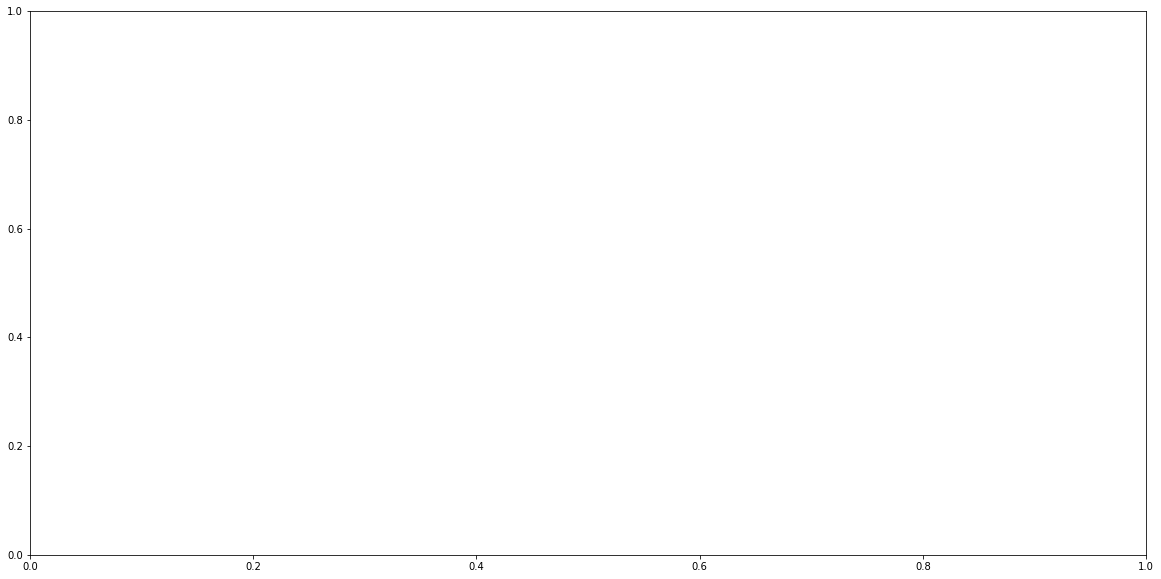

In [47]:
#plotting number of tweets as per days
fig,ax = plt.subplots(figsize=(20,10))
plt.plot(df_time_pandas.tweets_per_day)

plt.xlabel("Date")
plt.ylabel("Number of tweets")

plt.ylim(ymin = 0, ymax = 4000)

plt.title("Tweets per day with a ticker")

plt.show()

# <span style = 'color:darkred'> Hashtags </span style>

In [ ]:
#df_hashtags = (df.select('tweet_id_str', "entities")
#                 .withColumnRenamed("text", "hashtag_array")
#              )

#df_hashtags = df_hashtags.select("tweet_id_str", explode(df_hashtags.hashtag_array).alias("hashtags"))

#df_hashtags = df_hashtags.select("tweet_id_str", lower(df_hashtags['hashtags']).alias("hashtags"))


In [ ]:
#df.show()

In [ ]:

#df_hashtags.createOrReplaceTempView("hashtagsSQL")
 
#df_top = spark.sql("SELECT hashtags, count(hashtags) as count FROM hashtagsSQL GROUP BY hashtags ORDER BY 2 DESC ").show()


In [ ]:
df.count()

In [ ]:
df_time_pandas.count()

In [ ]:
def sentiment:
    


f_sent = udf(sentiment, string())
result_sentiment = df.withColumn('text', sentiment(result.x))
